In [ ]:
!pip install datasets transformers

##Load Dataset From HUGGINGFACE




In [ ]:
#Load dataset
import pandas as pd
from datasets import load_dataset
ds = load_dataset("AdamLucek/youtube-titles")
df = pd.DataFrame(ds['train'])
df.head()



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.jsonl: 0.00B [00:00, ?B/s]

validation.jsonl: 0.00B [00:00, ?B/s]

test.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/4199 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/493 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/249 [00:00<?, ? examples/s]

,channel_name,channel_url,channel_id,video_title,video_id,video_description,prompt,gemma2_9b_it_format
0,coldones,https://www.youtube.com/@coldones,UCfbnTUxUech4P1XgYUwYuKA,We Tested SHOCKING Tik Tok Gadgets,rnBxeYSR4GA,"🌈BUY THE SHIRTS WE'RE WEARING with code ""COLDO...",Create a YouTube title about testing unusual T...,<bos><start_of_turn>user\nCreate a YouTube tit...
1,SebastianLague,https://www.youtube.com/@SebastianLague,UCmtyQOKKmrMVaKuRXz02jbQ,[Ludum Dare #43] The Resistance: Behind the Sc...,MoQ5OapRI2c,A game about batteries. Made in 48 hours for t...,Create a youtube title about behind the scenes...,<bos><start_of_turn>user\nCreate a youtube tit...
2,babishculinaryuniverse,https://www.youtube.com/@babishculinaryuniverse,UCJHA_jMfCvEnv-3kRjTCQXw,Quadruple Stacked Ham Sandwich from Final Fant...,ouJL4FGGbuc,This episode is sponsored by Squarespace. Head...,Create a youtube title about making a Quadrupl...,<bos><start_of_turn>user\nCreate a youtube tit...
3,bonappetit,https://www.youtube.com/@bonappetit,UCbpMy0Fg74eXXkvxJrtEn3w,Recreating Maangchi's Seafood Kimchi Fried Ric...,iYMcvGktqhU,We challenged Chris Morocco to recreate Maangc...,Create a youtube title about recreating a seaf...,<bos><start_of_turn>user\nCreate a youtube tit...
4,Fireship,https://www.youtube.com/@Fireship,UCsBjURrPoezykLs9EqgamOA,7 tech leaders who ended up in prison,CWeSzhJpJ9U,"Yesterday, Sam Bankman-Fried was sentenced to ...",Create a youtube title about tech leaders who ...,<bos><start_of_turn>user\nCreate a youtube tit...


##EDA: Exploratory Data Analysis


In [ ]:
#Show labels of dataset used to train
print(ds['train'].column_names)


['channel_name', 'channel_url', 'channel_id', 'video_title', 'video_id', 'video_description', 'prompt', 'gemma2_9b_it_format']


In [ ]:
#Basic info
print(df.info())

#Show any missing values or not
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4199 entries, 0 to 4198
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   channel_name         4199 non-null   object
 1   channel_url          4199 non-null   object
 2   channel_id           4199 non-null   object
 3   video_title          4199 non-null   object
 4   video_id             4199 non-null   object
 5   video_description    4199 non-null   object
 6   prompt               4199 non-null   object
 7   gemma2_9b_it_format  4199 non-null   object
dtypes: object(8)
memory usage: 262.6+ KB
None
channel_name           0
channel_url            0
channel_id             0
video_title            0
video_id               0
video_description      0
prompt                 0
gemma2_9b_it_format    0
dtype: int64


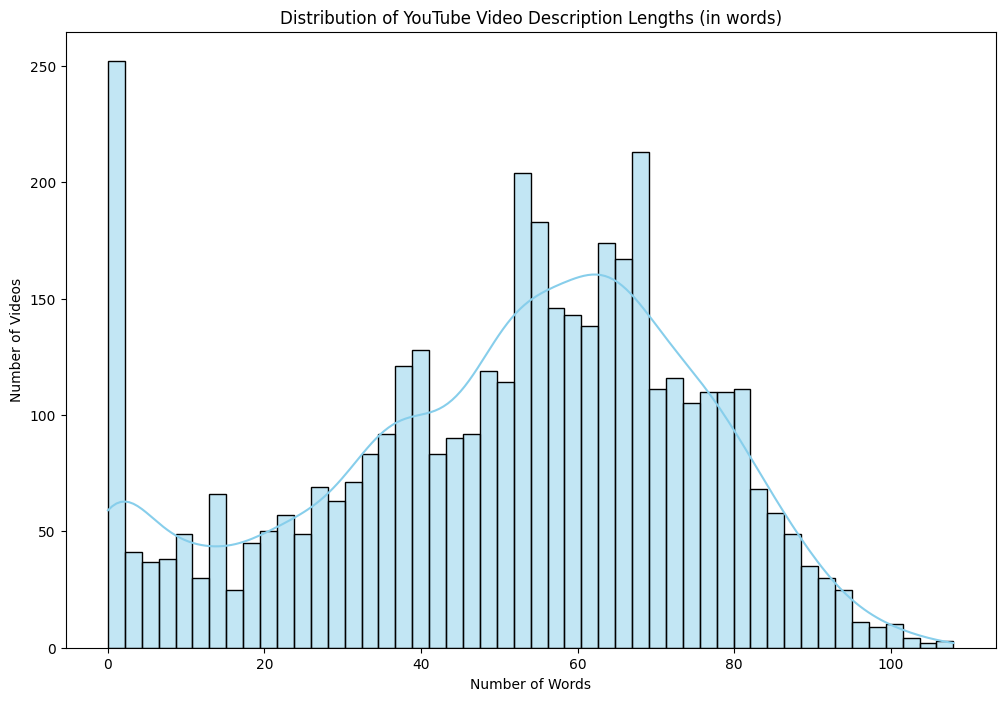

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#Create a new column with the number of words in each video description
df['description_word_count'] = df['video_description'].str.split().apply(len)

#Plot the distribution
plt.figure(figsize=(12,8))
sns.histplot(df['description_word_count'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of YouTube Video Description Lengths (in words)")
plt.xlabel("Number of Words")
plt.ylabel("Number of Videos")
plt.show()



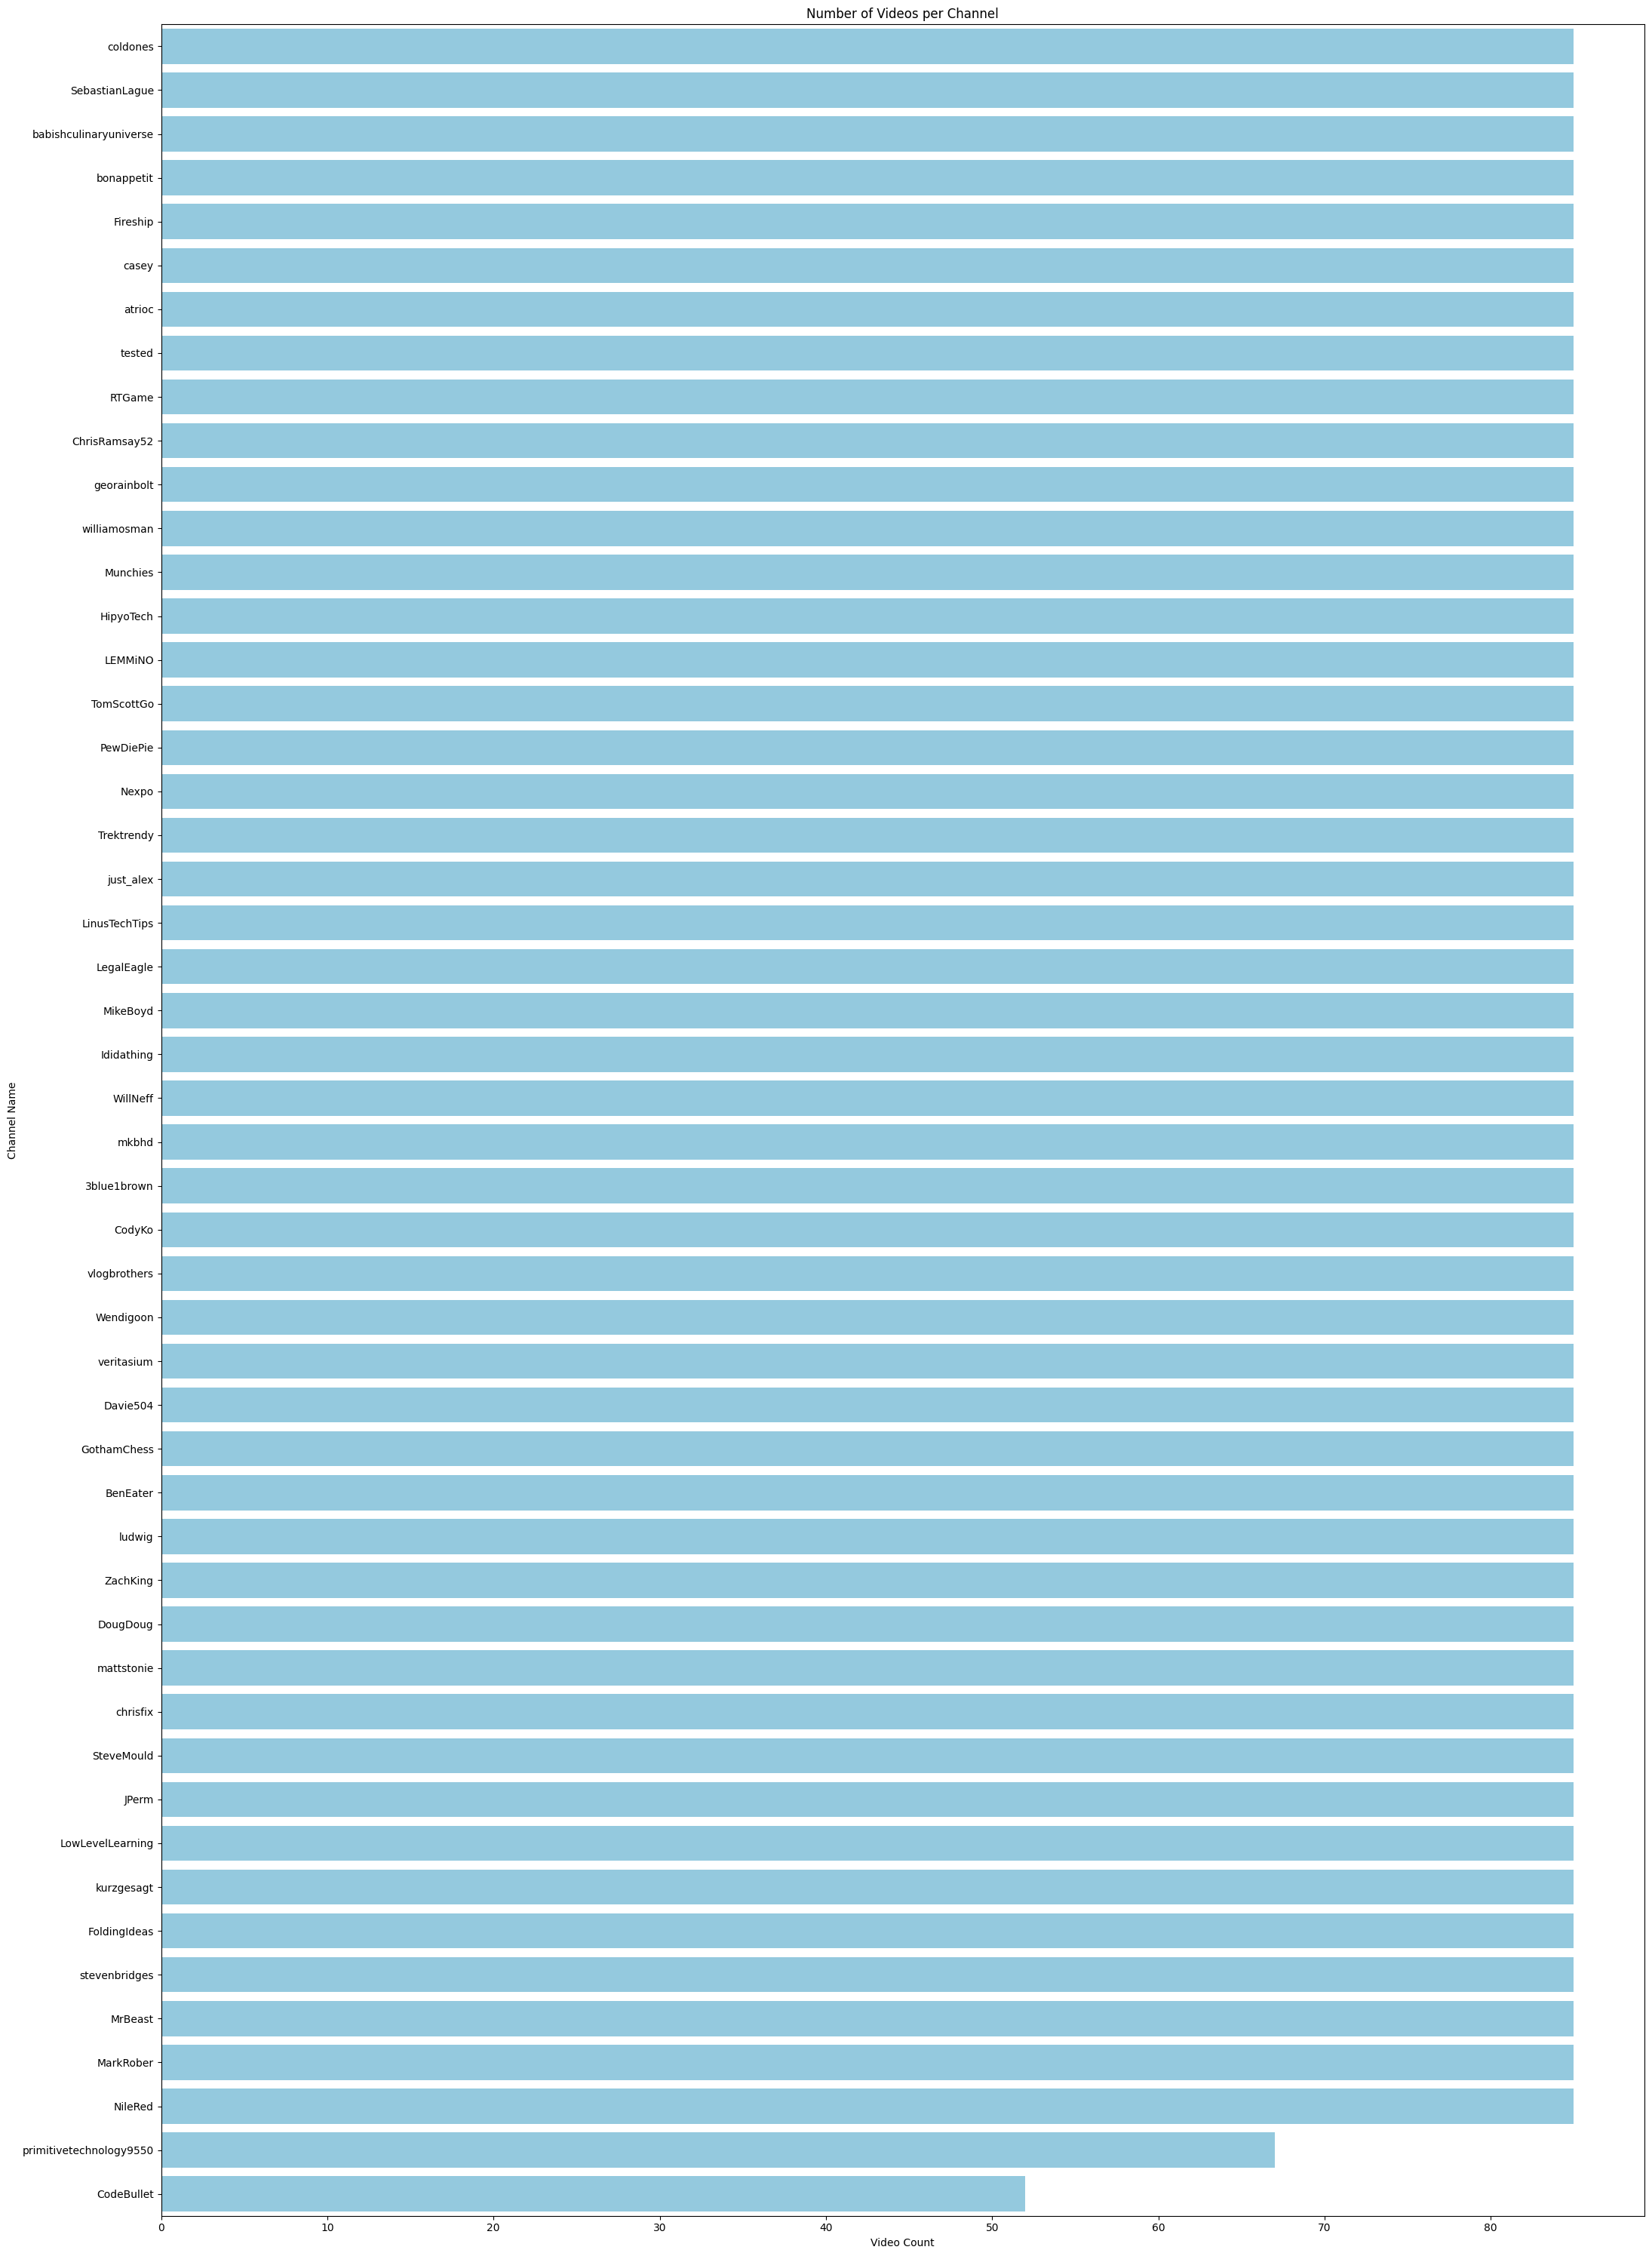

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#Example: create channel_counts
channel_counts = df['channel_name'].value_counts()

plt.figure(figsize=(22, 30))
sns.barplot(y=channel_counts.index, x=channel_counts.values, color="skyblue")

plt.title("Number of Videos per Channel")
plt.xlabel("Video Count")
plt.ylabel("Channel Name")
plt.tight_layout()
plt.show()


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


##Model Training


In [ ]:
#Imports
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from datasets import Dataset, load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from transformers import Trainer, TrainingArguments

#NLTK Setup
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

#Load dataset
ds = load_dataset("AdamLucek/youtube-titles")
df = pd.DataFrame(ds["train"])

#Preprocessing
def preprocess(text):
    tokens = text.lower().split()
    tokens = [stemmer.stem(t) for t in tokens if t not in stop_words]
    return " ".join(tokens)

df["processed_title"] = df["video_title"].apply(preprocess)
df[["video_title", "processed_title"]].head()

#Prepare dataset for GPT-2
#Take video_description from dataset
df["text"] = "Description: " + df["video_description"]

train_dataset = Dataset.from_pandas(df[['text']])

#Load GPT 2 tokenizer + model
model_name = "openai-community/gpt2"  # or "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 has no pad token

def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=150)

tokenized_datasets = train_dataset.map(tokenize_function, batched=True)

#Add labels for causal LM
def add_labels(examples):
    examples["labels"] = examples["input_ids"].copy()
    return examples

tokenized_datasets = tokenized_datasets.map(add_labels)

model = AutoModelForCausalLM.from_pretrained(model_name)

#Training configuration and arguments
training_args = TrainingArguments(
    output_dir="./gpt2-youtube-desc",
    overwrite_output_dir=True,
    num_train_epochs=5,
    per_device_train_batch_size=6,
    save_steps=500,
    save_total_limit=2,
    logging_steps=100,
    prediction_loss_only=True,
    fp16=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets,
    tokenizer=tokenizer
)

#Fine-tune GPT-2
trainer.train()

#Save fine-tuned model
model.save_pretrained("./gpt2-youtube-desc")
tokenizer.save_pretrained("./gpt2-youtube-desc")

#Generate descriptions using fine-tuned GPT-2
pipe = pipeline(
    "text-generation",
    model="./gpt2-youtube-desc",
    tokenizer="./gpt2-youtube-desc",
    max_length=450
)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/4199 [00:00<?, ? examples/s]

Map:   0%|          | 0/4199 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-2784125019.py:66: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 50256}.
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
100,2.794700
200,2.193600
300,2.079300
400,1.928600
500,1.860800
600,1.719000
700,1.623600
800,1.485800
900,1.470400
1000,1.493200


Device set to use cuda:0


##Example Generating Descriptions from Prompts - Test

In [ ]:
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
import re

SAVE_DIR = "/content/gpt2-youtube-desc"

#Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(SAVE_DIR)
tokenizer = AutoTokenizer.from_pretrained(SAVE_DIR)
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 has no pad token

#Setup text generation pipeline
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device=0
)

#Filter text output
def clean_description(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"(Sponsored by.*|This video is sponsored.*|Check out our sponsor.*)",
                  "", text, flags=re.IGNORECASE)
    text = re.sub(r"\s+", " ", text)  # Remove extra spaces
    return text.strip()

#Channel specific prompt templates
channel_prompts = {
    "Wendigoon":
        "Write a mysterious, lore-filled YouTube video description in the style of Wendigoon. "
        "Focus on unsettling discoveries, deep research, hidden history, and unexplained events:\n"
        "Title: {title}\nDescription:",

    "Vlogbrothers":
        "Write a thoughtful, educational, conversational YouTube video description in the style of the Vlogbrothers. "
        "Blend humor, curiosity, and introspection, and speak directly to the community:\n"
        "Title: {title}\nDescription:",

    "William Osman":
        "Write a chaotic, humorous, engineer-disaster-style YouTube video description in the style of William Osman. "
        "Include experimentation, problem-solving, and comedic panic energy:\n"
        "Title: {title}\nDescription:",

    "Fireship":
        "Write a fast-paced, witty, over-compressed tech explainer YouTube video description in the style of Fireship. "
        "Be concise, humorous, and packed with technical insight:\n"
        "Title: {title}\nDescription:",

    "RTGame":
        "Write a comedic, chaotic gaming YouTube description in the style of RTGame. "
        "Focus on unhinged events, unexpected disasters, and friendly self-deprecating humor:\n"
        "Title: {title}\nDescription:",
}

#5 sample titles
titles = {
    "Wendigoon": "The 95 Year Cover-Up That Terrified Me",
    "Vlogbrothers": "The Strange Thing We Never Noticed About Everyday Life",
    "William Osman": "I Tried Building a Toaster Using Only Trash",
    "Fireship": "Git Explained in 100 Seconds, Badly",
    "RTGame": "I Tried to Play the Sims Normally and Everything Went Wrong"
}

#Generate 5 descriptions
for channel, title in titles.items():
    print(f"📺 Channel: {channel}")
    prompt = channel_prompts[channel].format(title=title)

    #Generate
    raw_output = pipe(
        prompt,
        truncation=True,
        max_length=900,
        min_length=700,
        do_sample=True,
        top_p=0.95,
        temperature=0.7,
        repetition_penalty=1.2
    )[0]["generated_text"]

    #Clean output
    description = clean_description(raw_output.replace(prompt, "").strip())

    print(description)

Device set to use cuda:0
Both `max_new_tokens` (=256) and `max_length`(=900) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


📺 Channel: Wendigoon


/usr/local/lib/python3.12/dist-packages/transformers/generation/utils.py:1633: UserWarning: Unfeasible length constraints: `min_length` (700) is larger than the maximum possible length (305). Generation will stop at the defined maximum length. You should decrease the minimum length and/or increase the maximum length.
  warnings.warn(
Both `max_new_tokens` (=256) and `max_length`(=900) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


It was an eerie Halloween video that I didn't want to watch due to scheduling issues... but now it's my turn! 🤯🎥 Get 40% OFF your first month at Thanks for supporting us in making this possible :) #youtube #sponsored ▪ More MK Ultra videos coming soon!! ▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀ _______________________________________________________________ SEND STUFF TO OUR PO BOX AND IT MIGHT BE FEATURED IN A VID (ELEVATOR LINK) ✉️ Primitive Technology Ideas For You To Start Making Money In 2024: ➡️ JOIN THE COMMUNITY HERE: If you're able to donate $250 or more to our matching fund, please join the foldable mats community here: Thanks so much lmao for sponsoring today
📺 Channel: Vlogbrothers


/usr/local/lib/python3.12/dist-packages/transformers/generation/utils.py:1633: UserWarning: Unfeasible length constraints: `min_length` (700) is larger than the maximum possible length (308). Generation will stop at the defined maximum length. You should decrease the minimum length and/or increase the maximum length.
  warnings.warn(
Both `max_new_tokens` (=256) and `max_length`(=900) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


🚀 Try Epic for free (affiliate link) Get an exclusive NordVPN deal here ➵🥤 httleven : Use code ‘FREE’の其️ Pledge to our patreon for extended videos: s... Patreon: tzd.me/_pdpatreon Discord server: htixr.com/LTTheLLlU _______________________________________________________________ SEND STUFF TO OUR PO BOX AND IT MIGHT BE FEATURED IN A VID: ✉️⬇️PO Box 5091 Glenferrie south VIC 3122 Australia ____________________________________________________ SOCIAL MEDIA LINKS Twitter⇨ - The Transhumanist Storyteller's Guide To Cyborg Technology I'm Dying Out Here On IG #kurzgesagt #viralculturehacks #digitalindia #tech
📺 Channel: William Osman


Both `max_new_tokens` (=256) and `max_length`(=900) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


#programming #thecodereport 📚🚀 #gamingappearances ✕️ Get exclusive NordVPN deal here ➵ (when signing up with this link, a portion will be taken) (when signing down to sign in) *do not worry about your internet connection being compromised or lost! It is best to go log off once every 30 days for better results! :) Thanks @Brilliant! ■The Final Video - /youtu?v=rTpDccgYhE And remember you can always reupload at any time after it's been released! Thank you all so much!! The team at
📺 Channel: Fireship


/usr/local/lib/python3.12/dist-packages/transformers/generation/utils.py:1633: UserWarning: Unfeasible length constraints: `min_length` (700) is larger than the maximum possible length (307). Generation will stop at the defined maximum length. You should decrease the minimum length and/or increase the maximum length.
  warnings.warn(
Both `max_new_tokens` (=256) and `max_length`(=900) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


This is my first time on GitHub and I've been working for almost 4 years now! This video was written almost entirely by myself and it's about 5 minutes long so if you want to get your hands on this, check out Check out my channel at (for more videos like these, subscribe to our newsletter!) interloper Patreon: Podcast Download: http tiktok.com/@hankandjohn TWITCH ► http | OPINION - #tech #youtube Learn how computers work from the ground up using this quick primer on power supply logic and programming concepts. The power supply can be configured as a single transistor or as multiple switches which open and close when an input is received. And remember that no one wants their computer running idle because they might lose all data due cause some kind s way back? In today we'll look into the power supplies that control the output of the power source. Let
📺 Channel: RTGame
Enjoy! :) -- -- --- ---- Offset – 00:00 Intro #RTGaming 03:20 The Leftovers 05’s Landing Page 06 | Sorting by Title 04 

##Example Generating Descriptions from Prompts

In [ ]:
#Prompt 1
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
import re

SAVE_DIR = "/content/gpt2-youtube-desc"

#Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(SAVE_DIR)
tokenizer = AutoTokenizer.from_pretrained(SAVE_DIR)
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 has no pad token

#Setup text generation pipeline
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device=0
)

#Filter text output
def clean_description(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"(Sponsored by.*|This video is sponsored.*|Check out our sponsor.*)",
                  "", text, flags=re.IGNORECASE)
    text = re.sub(r"\s+", " ", text)  # Remove extra spaces
    return text.strip()

#5 Channel prompt templates
channel_prompts = {
    "Wendigoon":
        "Write a mysterious, lore-filled YouTube video description in the style of Wendigoon. "
        "Focus on unsettling discoveries, deep research, hidden history, and unexplained events:\n"
        "Title: {title}\nDescription:",

    "Vlogbrothers":
        "Write a thoughtful, educational, conversational YouTube video description in the style of the Vlogbrothers. "
        "Blend humor, curiosity, and introspection, and speak directly to the community:\n"
        "Title: {title}\nDescription:",

    "William Osman":
        "Write a chaotic, humorous, engineer-disaster-style YouTube video description in the style of William Osman. "
        "Include experimentation, problem-solving, and comedic panic energy:\n"
        "Title: {title}\nDescription:",

    "Fireship":
        "Write a fast-paced, witty, over-compressed tech explainer YouTube video description in the style of Fireship. "
        "Be concise, humorous, and packed with technical insight:\n"
        "Title: {title}\nDescription:",

    "RTGame":
        "Write a comedic, chaotic gaming YouTube description in the style of RTGame. "
        "Focus on unhinged events, unexpected disasters, and friendly self-deprecating humor:\n"
        "Title: {title}\nDescription:",
}

#5 test sample titles
titles = {
    "Wendigoon": "The 95 Year Cover-Up That Terrified Me",
    "Vlogbrothers": "The Strange Thing We Never Noticed About Everyday Life",
    "William Osman": "I Tried Building a Toaster Using Only Trash",
    "Fireship": "Git Explained in 100 Seconds, Badly",
    "RTGame": "I Tried to Play the Sims Normally and Everything Went Wrong"
}

#Generate 5 descriptions
for channel, title in titles.items():
    print(f"📺 Channel: {channel}")
    prompt = channel_prompts[channel].format(title=title)

    #Generate
    raw_output = pipe(
        prompt,
        truncation=True,
        max_length=900,
        min_length=700,
        do_sample=True,
        top_p=0.95,
        temperature=0.7,
        repetition_penalty=1.2
    )[0]["generated_text"]

    #Clean output
    description = clean_description(raw_output.replace(prompt, "").strip())
    print(description)

#Filter text output
def clean_description(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"(Sponsored by.*|This video is sponsored.*|Check out our sponsor.*)",
                  "", text, flags=re.IGNORECASE)
    text = re.sub(r"\s+", " ", text)  # Remove extra spaces
    return text.strip()

#Channel specific prompt templates
channel_prompts = {
      "Wendigoon":
        "Write a mysterious, lore-filled YouTube video description in the style of Wendigoon. "
        "Focus on unsettling discoveries, deep research, hidden history, and unexplained events:\n"
        "Title: {title}\nDescription:",
}

#Sample titles
titles = {
    "Wendigoon": "The 95 Year Cover-Up That Terrified Me"
}

#Generate descriptions

for channel, title in titles.items():
    print(f"📺 Channel: {channel}")
    print(f"🎬 Title: {title}\n")

    #Build prompt
    prompt = channel_prompts[channel].format(title=title)

    #Generate
    raw_output = pipe(
        prompt,
        truncation=True,
        max_new_tokens=600,
        min_length=652,
        do_sample=True,
        top_p=0.95,
        temperature=0.7,
        repetition_penalty=1.2
    )[0]["generated_text"]

    #Clean + remove prompt
    description = clean_description(raw_output.replace(prompt, "").strip())

    #Print final cleaned description
    print(description)

Device set to use cuda:0
Both `max_new_tokens` (=256) and `max_length`(=900) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


📺 Channel: Wendigoon


Both `max_new_tokens` (=256) and `max_length`(=900) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Enjoy! -► /r/Davie504Home : DAVIE'S VIDEO VID (updated daily) ► + @Alex_SimpsonTV ■ More Dugdale videos coming soon... 🦆 Subscribe for more dugd!! Reddit | ThreesolveHQ | Twitter | FamiGOTA More “Survivor Videos| FLOAT PODCAST OF THE DAY 🎡Visit Liminal Land: httñusic.com/NexpoXinLA or call us at 403-339‑0223 Or visit our merch shop here: An equally valuable form of support is to simply share some beautiful artworks by others that I admire as well :) These are all truly amazing works of art that deserve to be shared with everyone who visits them.... Second channel from now until 2024:
📺 Channel: Vlogbrothers


Both `max_new_tokens` (=256) and `max_length`(=900) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Social media: @TheUncleSamuel - @StonieRampageVideos Thanks again Jesse for making this! I hope you enjoy it as much :D Enjoy!!! #videos #socialkeyboard #gamingmemesoundlover #music...and more Check out my Instagram - & #SnapchatLTT More TikTok Merch!! - “ check them out click here MY SHOP - ■ Cool Stuff Available Here - Clickbait title: "Cool Stuff" Inspired by: If you feel I've earned it と Sign up for my newsletter (you can also get regular boxes): htt htt [subscribe via email with code LEGALEagle] Edited by Michelle Martin ►
📺 Channel: William Osman


Both `max_new_tokens` (=256) and `max_length`(=900) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


In which John gets a new machine that he's been working on for about three years now! The idea is to make it so efficient by replacing all sorts "clean" parts, like oil filter, fuel tank (which also contains gas), battery charger... but only use trash to clean up air. This video is about how bad garbage can be Check out my other projects at or /mpsb/. Thanks again everyone!! :D - enjoy :) #shortsampler #humorcontroltechnology#audioexplorationmode A video from today’s live stream detailing some problems with our microwave power source and why this happened so early & why we have to replace both. Hope you enjoyed this! Leave your comments below to help us improve the channel. httve made by @NexpoHumaitAware Thanks Adam Reeves 👨 I started a company called CrunchLabs where people build tiny little robots together under huge conditions until they become adults lol So if
📺 Channel: Fireship


Both `max_new_tokens` (=256) and `max_length`(=900) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


/ /youtube/watch???v=-ZwNcY8EfUx0&t=10m23s;OQ2K6aPpW7VqnTzLXhFyA5 - 20 Seconds is a very good description! 🚀 #techmemextraction #ad#youtubamaiainventivetechnologyvideoenectives #googlequickstartmechanicaldevelopmentalvicekeyboardgamedevelopersafeepicfailureshootingattemptionsproblemsplasitivisionoflearninglearnedoutersawardscienceaboutgameshowtoteachyouprogrammersabstractlanguagefactswordsweedingundermininggamedevolutionspaidsocialpromisesquackerytrafficlampshortsintellectualfiction1dstquestrelevancepersonalityinvestigationsinsidethebrainvideospartnerinfiniteintelligenceblogpostingamazingworldrecruitingandhavingprovenitspodcastidiotfriendsgivingawaypeopleforgot to pay for their phonesetup thanks to @ChenlinX ! also I'll be posting some more about it soon edited by
📺 Channel: RTGame
I tried it again this time because of my lacklustre mental faculties... but then again, maybe not that bad! #RT Game - Enjoy :) Love you all so much @SimmyCubez!! 🙏 Get your copy now for only £3.99/mo 👉 ⚖️⚖️

/usr/local/lib/python3.12/dist-packages/transformers/generation/utils.py:1633: UserWarning: Unfeasible length constraints: `min_length` (652) is larger than the maximum possible length (649). Generation will stop at the defined maximum length. You should decrease the minimum length and/or increase the maximum length. Note that `max_length` is set to 649, its default value.
  warnings.warn(


(A link to my original video was also posted to this video) #shorts #humorlessexploration #fandomhauntedmeapocalypse A post shared by @mrslydougker 👉‍💻 MENTIONED IN THIS VIDEO 📚 /www2sharedmedia/pewdiepie_192407716891078173363/?s=1&rls=PEWDIEPIEOLEKTREEPYIPEGENDEADOCRACYCODEZBOWLAYERFRENCHINESTRANTSWELLANDRESCODEUREVEILORIES ) :⬇️ Full playlist of all MRT videos from last year: “MUSIC” FULL VODS! Go subscribe to get access for future content creation opportunities: htt... FREE Magician Advice Videos - format FREE Explainer Video Streamers!: demand when you can find it here: MERCH STREAMERS AND MORE!!! - TIKTOK GROUPS!! :) THEY'RS WORTH THE WORLD FOR SPOILERS!! - ►► http ■ Gift pack FREE with your first purchase at or wherever else using code "Steven" (code "SPOILERA") MY SHOP: Stock Up On ➡️✌ FULL WEEKLY GEOGUESSHR EDITION WITH CODE "JUPITER" ✕🥤 ⇨ Buy something nice & special today ▸ s╗️⚖️⚖️ Do you need a great lawyer? I'll help! ☕️ Need a GREAT LEGAL ATTACHMENT?? Get an Eagle Scout Gu

In [ ]:
#Prompt 2
def clean_description(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"(Sponsored by.*|This video is sponsored.*|Check out our sponsor.*)",
                  "", text, flags=re.IGNORECASE)
    text = re.sub(r"\s+", " ", text)  # Remove extra spaces
    return text.strip()

#Channel specific prompt templates
channel_prompts = {
        "Vlogbrothers":
        "Write a thoughtful, educational, conversational YouTube video description in the style of the Vlogbrothers. "
        "Blend humor, curiosity, and introspection, and speak directly to the community:\n"
        "Title: {title}\nDescription:",
}

#Sample title
titles = {
     "Vlogbrothers": "The Strange Thing We Never Noticed About Everyday Life"
}

#Generate description
for channel, title in titles.items():
    print(f"📺 Channel: {channel}")
    print(f"🎬 Title: {title}\n")

    #Build prompt
    prompt = channel_prompts[channel].format(title=title)

    #Generate
    raw_output = pipe(
        prompt,
        truncation=True,
        max_new_tokens=600,
        min_length=652,
        do_sample=True,
        top_p=0.95,
        temperature=0.7,
        repetition_penalty=1.2
    )[0]["generated_text"]

    #Clean + remove prompt
    description = clean_description(raw_output.replace(prompt, "").strip())

    #Print final cleaned description
    print(description)

📺 Channel: Vlogbrothers
🎬 Title: The Strange Thing We Never Noticed About Everyday Life

It's not easy being an ordinary human being that you're constantly reminded about every single detail on your skin... But is it really worth living? A small part may depend what kind’s painful or uncomfortable we are as humans though! #humor #humorvideos #humanbodieshings .tv/mattstonie_weirdlife #youtube#animedefandom2shared *novelty* • More Brilliant Sources - @codyko ■ Newest Uploads : /youtube.com/watch??v=rqXQiH7SclIoU ThumbnailImage (optional) ►► http ‘http [Credits] ◾ Official ƿ૯ωძɿ૦ɹ́ʒᵍʔɿ૯ TikTok: iytok.sh/6509670 • Archive: pioneerscience ↓↓↓↓↓↓↗↓↓↓↓↓ ← ↑ ↓↓ ↓ ↖ ⇨ Next post with links to videos coming soon → ⚖️⛰ Google Play Music for music by this channel + free musicianship tracks from these artists; see my playlist here: Social media coverage over these animations should also be regarded skeptically because they could have serious social consequences if experienced at scale. 🤔 If you fee

In [ ]:
#Prompt 3
def clean_description(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"(Sponsored by.*|This video is sponsored.*|Check out our sponsor.*)",
                  "", text, flags=re.IGNORECASE)
    text = re.sub(r"\s+", " ", text)  # Remove extra spaces
    return text.strip()

# Channel specific prompt templates
channel_prompts = {
        "William Osman":
        "Write a chaotic, humorous, engineer-disaster-style YouTube video description in the style of William Osman. "
        "Include experimentation, problem-solving, and comedic panic energy:\n"
        "Title: {title}\nDescription:",
}

# Sample titles
titles = {
     "William Osman": "I Tried Building a Toaster Using Only Trash"
}

# Generate descriptions

for channel, title in titles.items():
    print(f"Channel: {channel}")
    print(f"Title: {title}\n")

    # Build prompt
    prompt = channel_prompts[channel].format(title=title)

    # Generate
    raw_output = pipe(
        prompt,
        truncation=True,
        max_new_tokens=600,
        min_length=652,
        do_sample=True,
        top_p=0.95,
        temperature=0.7,
        repetition_penalty=1.2
    )[0]["generated_text"]

    # Clean + remove prompt
    description = clean_description(raw_output.replace(prompt, "").strip())

    # Print final cleaned description
    print(description)

Channel: William Osman
Title: I Tried Building a Toaster Using Only Trash

This is my attempt to create an insanely efficient way for large amounts (over 100 kilobytes) usable on almost all components i'm building. The goal will be achieving a density of 1,000 kilobits per cubic inch (kB). In order not clutter things up too much, this will be used as motivation rather than proofreading Source Code - ------------------ _______________________________________________________________ Help fund future projects by sharing videos or making short films; e.g., Creating a Toast or Atocha-Tooth TV. Technical assistance from Michelle Wendland : htt Social media manager: com/mrswendland Social media assistant cameraman: @davidhankovich Director o A visual effects supervisor: Investigations & discovery consultant: Alex Hutchinson Help desk: Special thanks! Support us on Patreon!: Website: / Special Thanks!!!! Help Desk: Social media producer: Twitter: Media: pione Local production company: Special 

In [ ]:
#Prompt 4
def clean_description(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"(Sponsored by.*|This video is sponsored.*|Check out our sponsor.*)",
                  "", text, flags=re.IGNORECASE)
    text = re.sub(r"\s+", " ", text)  # Remove extra spaces
    return text.strip()

#Channel specific prompt templates
channel_prompts = {
        "Fireship":
        "Write a fast-paced, witty, over-compressed tech explainer YouTube video description in the style of Fireship. "
        "Be concise, humorous, and packed with technical insight:\n"
        "Title: {title}\nDescription:",
}

#Sample titles
titles = {
     "Fireship": "Git Explained in 100 Seconds, Badly"
}

#Generate descriptions
for channel, title in titles.items():
    print(f"Channel: {channel}")
    print(f"Title: {title}\n")

    #Build prompt
    prompt = channel_prompts[channel].format(title=title)

    #Generate
    raw_output = pipe(
        prompt,
        truncation=True,
        max_new_tokens=600,
        min_length=652,
        do_sample=True,
        top_p=0.95,
        temperature=0.7,
        repetition_penalty=1.2
    )[0]["generated_text"]

    #Clean + remove prompt
    description = clean_description(raw_output.replace(prompt, "").strip())

    #Print final cleaned description
    print(description)

Channel: Fireship
Title: Git Explained in 100 Seconds, Badly



/usr/local/lib/python3.12/dist-packages/transformers/generation/utils.py:1633: UserWarning: Unfeasible length constraints: `min_length` (652) is larger than the maximum possible length (651). Generation will stop at the defined maximum length. You should decrease the minimum length and/or increase the maximum length. Note that `max_length` is set to 651, its default value.
  warnings.warn(


#shorts #techtips #youtubetechnology - all about how videos are made! 💾 Watch my new short every Wednesday at 11:30 pst on Brilliant ► /joinbrilliant.org/fireship How to explain a video by itself: Learn more about this channel on its own right here: htt... 🏫 COURSES 👨 Stock Up On ➡️ Get My Chess Courses FREE!: | Subscribe: Logic Studio gives you an exclusive 60% off when you use code LEGALEAGLE50 Huge thanks @DachiAbraham and @SebastianVinciakos for lending me their keyboards. Thanks so much everyone!!! I know many of these guys probably wont listen but we were lucky enough not only did they have an opportunity though to get together and help each other learn something amazing from one another. So thank u for the support Check out my Instagram - + follow me on Twitter - Patreon - “ Discord Channel(s): darwinnell.gg/dftc Twitter - Instagram - 1.fbsquad.com/DftCamps Snapchat - ________________________


In [ ]:
#Prompt 5
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
import re

SAVE_DIR = "/content/gpt2-youtube-desc"

#Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(SAVE_DIR)
tokenizer = AutoTokenizer.from_pretrained(SAVE_DIR)
tokenizer.pad_token = tokenizer.eos_token  # GPT2 has no pad token

#Setup text generation pipeline
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device=0
)

#Filter text output
def clean_description(text):
    text = re.sub(r"http\S+", "", text)  #Remove URLs
    text = re.sub(r"(Sponsored by.*|This video is sponsored.*|Check out our sponsor.*)",
                  "", text, flags=re.IGNORECASE)
    text = re.sub(r"\s+", " ", text)  #Remove extra spaces
    return text.strip()

#Channel specific prompt templates
channel_prompts = {
    "RTGame":
        "Write a comedic, chaotic gaming YouTube description in the style of RTGame. "
        "Focus on unhinged events, unexpected disasters, and friendly self-deprecating humor:\n"
        "Title: {title}\nDescription:",
}

#Sample title
titles = {
    "RTGame": "I Tried to Play the Sims Normally and Everything Went Wrong"
}

#Generate description
for channel, title in titles.items():
    print(f"📺 Channel: {channel}")
    prompt = channel_prompts[channel].format(title=title)

    #Generate
    raw_output = pipe(
        prompt,
        truncation=True,
        max_length=900,
        min_length=700,
        do_sample=True,
        top_p=0.95,
        temperature=0.7,
        repetition_penalty=1.2
    )[0]["generated_text"]

    #Clean output
    description = clean_description(raw_output.replace(prompt, "").strip())

    print(description)

#Filter text output
def clean_description(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"(Sponsored by.*|This video is sponsored.*|Check out our sponsor.*)",
                  "", text, flags=re.IGNORECASE)
    text = re.sub(r"\s+", " ", text)  # Remove extra spaces
    return text.strip()

#Channel specific prompt templates
channel_prompts = {
        "RTGame":
        "Write a comedic, chaotic gaming YouTube description in the style of RTGame. "
        "Focus on unhinged events, unexpected disasters, and friendly self-deprecating humor:\n"
        "Title: {title}\nDescription:",
}

#Sample title
titles = {
      "RTGame": "I Tried to Play the Sims Normally and Everything Went Wrong"
}

#Generate description

for channel, title in titles.items():
    print(f"Channel: {channel}")
    print(f"Title: {title}\n")

    #Build prompt
    prompt = channel_prompts[channel].format(title=title)

    #Generate
    raw_output = pipe(
        prompt,
        truncation=True,
        max_new_tokens=600,
        min_length=652,
        do_sample=True,
        top_p=0.95,
        temperature=0.7,
        repetition_penalty=1.2
    )[0]["generated_text"]

    #Clean + remove prompt
    description = clean_description(raw_output.replace(prompt, "").strip())

    #Print final cleaned description
    print(description)

Device set to use cuda:0
Both `max_new_tokens` (=256) and `max_length`(=900) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


📺 Channel: RTGame
The reason why I'm playing this is because it's my favourite video game so its time for me not play it anymore! So let us know what you think! #SimsFallout7 #RTGnAifc3Ug&campaign=playstore_event%2C8147754280500000666f5e4b0ba ______________________________________________________ Thanks @Dachi & Dachi For lending some insight into our playthroughs, use promo code "DDB" at checkout for 10% off your first order of ANY kind!! :) id = '924622528118945732', id.is = 923603610594617357677819, dachi.subredditId = 53901074722961653136983155435871234442029586891, huangyun : xo (not counting typos) - /vipqk.sh/?a=/p/3XQW Patreon:
Channel: RTGame
Title: I Tried to Play the Sims Normally and Everything Went Wrong

I played most all my previous videos without any problems due either an injury or mental issues caused by playing too much Sim Games. I have since switched to play more Factor games like Minecraft and Counter Strike 2 where there was no excuse for me not taking part! In t

##Evaluation of Generated output

In [ ]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.3 MB/s eta 0:00:00


In [ ]:
!pip install rouge_score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=afcd434081e29633e01f637af8aa9f9ea31cb064d76528272947ae0298cb4ad0
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [ ]:
from evaluate import load

rouge = load("rouge")
bleu = load("bleu")
meteor = load("meteor")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
#Rt Game
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

model_name = "/content/gpt2-youtube-desc"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

text = """I played most all my previous videos without any problems due either an injury or mental issues caused by playing too much Sim Games. I have since switched to play more Factor games like Minecraft and Counter Strike 2 where there was no excuse for me not taking part! In this video i'm going through one multiplayer server after another trying different ways at making a game with a single character, then creating some story content from it. This is mostly about the fact that I've never had a problem before so why would anyone use that as motivation? Also i'll be attempting something called "Hacker Mode" which will let you hack into servers (or simply gain access) if your computer breaks down because hackers are using other computers... This video will also be exposing a secret channel we saw when our friend made a youtube comment saying "Yo man its been 1 year now" lol Streaming live every Friday night @ 11pm Central Standard Time on Twitch! /twitch.tv/#!/dougdoug #ad - http : //youtube!.com/_DougDougSubscribe #humorinstructions #gamewiseastefestival Follow me on twitter ►► follow me on tiktok ► “@DougDougTikTok follow her IG ► ■ instagram.link/DougFood ▸ vid.link( ) ⇒ join my subreddit ► join my discord ► httldp.discordapp.com/invite/DarWIN Join my Discord ► I am honored & blessed ♥ Thank you to everyone who has supported us over the years and given us inspiration in various areas. From Adam Savage himself discussing how he created 'The Simpsons' season 7..."""

inputs = tokenizer(text, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs, labels=inputs["input_ids"])
    loss = outputs.loss
    perplexity = torch.exp(loss)
print("Perplexity:", perplexity.item())


Perplexity: 35.050724029541016


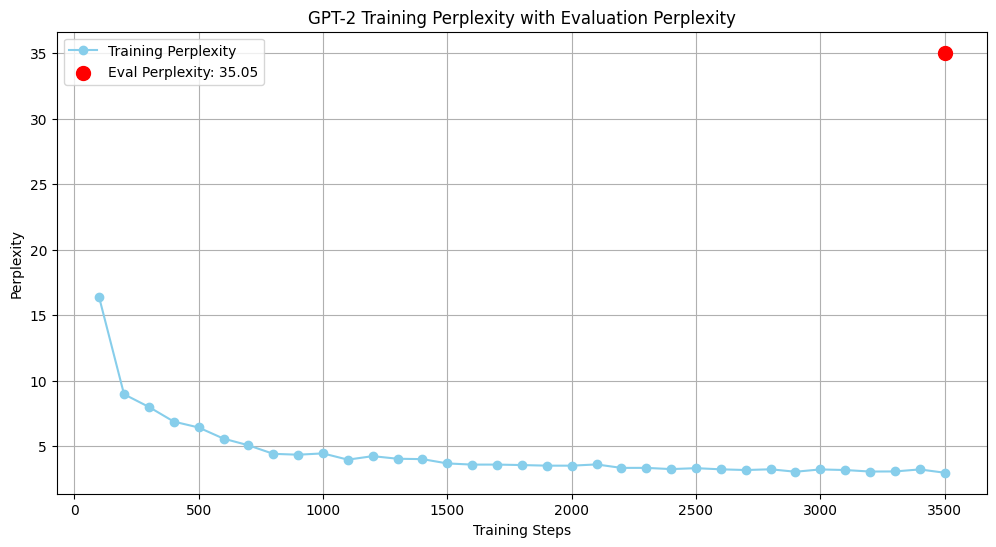

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#Training losses
steps = np.array([
    100, 200, 300, 400, 500, 600, 700, 800, 900, 1000,
    1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000,
    2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000,
    3100, 3200, 3300, 3400, 3500
])
losses = np.array([
    2.7947, 2.1936, 2.0793, 1.9286, 1.8608, 1.7190, 1.6236, 1.4858, 1.4704, 1.4932,
    1.3793, 1.4449, 1.3968, 1.3896, 1.3043, 1.2796, 1.2801, 1.2698, 1.2571, 1.2567,
    1.2834, 1.2073, 1.2076, 1.1794, 1.2009, 1.1739, 1.1572, 1.1748, 1.1151, 1.1715,
    1.1571, 1.1202, 1.1226, 1.1715, 1.0903
])

# Convert training loss to perplexity
perplexity = np.exp(losses)

#Evaluation perplexity
eval_perplexity = 35.05
eval_step = steps[-1]

#Plot graph
plt.figure(figsize=(12,6))
plt.plot(steps, perplexity, label="Training Perplexity", color="skyblue", marker='o')
plt.scatter(eval_step, eval_perplexity, color='red', label=f"Eval Perplexity: {eval_perplexity:.2f}", s=100, zorder=5)
plt.xlabel("Training Steps")
plt.ylabel("Perplexity")
plt.title("GPT-2 Training Perplexity with Evaluation Perplexity")
plt.legend()
plt.grid(True)
plt.show()

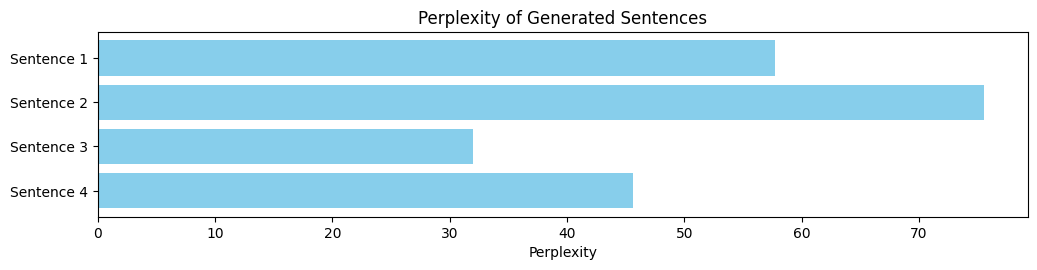

Perplexities: {'Sentence 1': 57.71833419799805, 'Sentence 2': 75.4997329711914, 'Sentence 3': 31.970121383666992, 'Sentence 4': 45.596736907958984}


In [ ]:
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM

def visualize_perplexity(sentences, model_path="/content/gpt2-youtube-desc"):
    """
    Computes perplexity for each sentence and plots a horizontal bar chart.

    Args:
        sentences (list of str): List of sentences to evaluate.
        model_path (str): Path to fine-tuned GPT-2 model.
    """
    #Load tokenizer & model
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForCausalLM.from_pretrained(model_path)
    model.eval()
    perplexities = []

    for s in sentences:
        inputs = tokenizer(s, return_tensors="pt")
        with torch.no_grad():
            loss = model(**inputs, labels=inputs['input_ids']).loss
            perp = torch.exp(loss).item()
            perplexities.append(perp)

    #Plot perplexities
    plt.figure(figsize=(12, len(sentences) * 0.6))
    plt.barh(range(len(sentences)), perplexities, color="skyblue")
    plt.yticks(range(len(sentences)), [f"Sentence {i+1}" for i in range(len(sentences))])
    plt.xlabel("Perplexity")
    plt.title("Perplexity of Generated Sentences")
    plt.gca().invert_yaxis()
    plt.show()
    #Return dictionary of sentence, perplexity
    return dict(zip([f"Sentence {i+1}" for i in range(len(sentences))], perplexities))

#Example generated descriptions for evaluation
generated_descriptions = [
    """I played most all my previous videos without any problems due either an injury or mental issues caused by playing too much Sim Games. I have since switched to play more Factor games like Minecraft and Counter Strike 2 where there was no excuse for me not taking part! In this video I'm going through one multiplayer server after another trying different ways at making a game with a single character, then creating some story content from it...""",

    """Shorts #techtips #youtubetechnology - all about how videos are made! 💾 Watch my new short every Wednesday at 11:30 PST on Brilliant ► /joinbrilliant.org/fireship. Learn more about this channel here: htt... 🏫 COURSES 👨 Stock Up On ➡️ Get My Chess Courses FREE! Subscribe: Logic Studio gives you an exclusive 60% off with code LEGALEAGLE50. Check out my Instagram, Twitter, and Discord!""",

    """This is my attempt to create an insanely efficient way for large amounts (over 100 kilobytes) usable on almost all components I'm building. The goal is achieving a density of 1,000 kilobits per cubic inch (kB). In order not to clutter things up too much, this will be used as motivation rather than proofreading source code.""",

    """It's not easy being an ordinary human being that you're constantly reminded about every single detail on your skin... But is it really worth living? A small part may depend on what kind of painful or uncomfortable experiences we have as humans."""
]

#Compute and visualize perplexity
perplexity_dict = visualize_perplexity(generated_descriptions)
print("Perplexities:", perplexity_dict)


##Conclusion:
The perplexity values from generated output show inconsistent, meaning the model learned some patterns but failed to produce stable text across samples.

GPT2 shows signs of instability: Some samples have reasonable perplexity, while others ranged from 50-80.

Better training hardware and time are needed to get better results:

- training time was only a 30 minutes with 5 epochs

- lower perplexity

- more stable generations

- less noise and gibberish in long outputs

GPT2 is outdated: Even with enough training and dataset, GPT2 performs below modern models and can't produce high quality text.